If you've taken any kind of stats course, you've come across things like t-tests, ANOVAs, and other members of the GLM family. You should know that they return p-values, or the odds that your sample (or samples) were drawn from noise. So, if you have two sets of numbers, setA and setB, the p-value refers to the odds that you'd observe a difference like the one you did (or larger) if they were, in fact, drawn from the same distribution. If the null were true (and they're from the same pool), you'd come up with your data (or more extreme) p-value percent of the time.   

Now, this leads to two types of errors you'd also heard about. Type I errors are often the most feared as those are "false positives" - the truth is there is no difference, but you still observed one.  Type II are "false negatives" - something was there, but you didn't see it. We're taught a few things about the GLM and one of the big ones is that the assumption that your data are "normally distributed". If they are, the test is valid. If not, the test isn't valid and you should either fix your data (transform it to make it normally distributed) or look elsewhere (say to a non-parametric test in classical frequentist statistics). 

In this project, we're going to play around a bit with this and see just what happens when these assumptions are violated.  It'll give us a good bit of practice in simulating data and in running statistical tests. It'll also let us see that the t-test (and its GLM kin) are actually quite robust to Type I errors when normality is violated. It's not, however, robust to Type II errors. If you want to read up on this effect, here's a 
[nice paper on this](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3139856/).

At the end, we'll code up a permutation test that computes the probability via brute force. These are getting more and more popular now that we have fast computers and don't do our statisitcs on ink quill pens and parchment.


First, write a function `GenNormalSamples` that generates two random sets of numbers using `scipy.stats.norm`. Parameters to the function should include the number of samples per group (`nsamples` defaulting to 10), the mean and standard deviation of setA (`meanA` defaulting to 0 and `stdA` defaulting to 1) and the same for setB (`meanB` and `stdB`). Numbers should be drawn from a normal random (Gaussian) distribution.  Return the `nsamples`x2 numpy array.

To check this out, use `plt.hist` to plot both your histograms on the same axes of the results from `GenNormalSamples(100,meanB=1.0)`.

In [ ]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
def GenNormalSamples(nsamples=10, meanA=0.0, stdA=1.0, meanB=0.0, stdB=1.0):
    # Your code here...
    return result

data=GenNormalSamples(100,meanB=1.0)
plt.hist(data)


Next, write a function `CheckTtest` that calls `GenNormalSamples` `ntest` times (defult=1000) to generate random data and then calls `scipy.stats.ttest_ind` each time to test whether a standard t-test thinks these samples, in fact, come from different distributions. This function should take the same `nsamples`, `meanA/B` and `stdA/B` variables as `GenNormalSamples` and should pass these through to `GenNormalSamples`. 

From each call, keep track of the p-value returned. At the end, print out a nice statement that says "Out of ## tests, ## were significant, for a test positivity rate of 0.##". Use a p\<0.05 threshold as your "significant" rate.

Run your test with the default values (it should return roughly 0.05) and also with a few values of your choosing.

In [ ]:
import numpy as np
from scipy.stats import ttest_ind

def CheckTtest(ntests=1000,nsamples=10,meanA=0,stdA=1,meanB=0,stdB=1):
    # Your code here...

CheckTtest()
CheckTtest(meanB=1)

Now, copy your `GenNormalSamples` function and re-write it to create a skewed sample. Instead of using `scipy.stats.norm`, you'll use `scipy.stats.exponnorm`. 

This function takes a K parameter that controls the skew. K here must be >0, but 0 would be an actually un-skewed distribution. So, make sure to clip whatever K is passed in to a very small number like 0.0001 to approximate an unskewed normal distribution well enough.  Set the default `k` to be 0 so that by default, this does make a "normal" distribution sample.


Make the histogram you did as before, but use a k=20 this time.  

In [ ]:
import numpy as np
from scipy.stats import exponnorm
from matplotlib import pyplot as plt
def GenNormalSamples(nsamples=10, meanA=0.0, stdA=1.0, meanB=0.0, stdB=1.0,k=0.0):
    # Your code here...

data=GenNormalSamples(100,meanB=1.0,k=20.0)
plt.hist(data)


Copy your `CheckTtests` in here as well also adjust it to take the `k` parameter. Run it as before. What happens to the test positive rates when you use a value like k=20? Does it behave according to how we want it to behave?


In [ ]:
from scipy.stats import ttest_ind

def CheckTtest(ntests=1000,nsamples=10,meanA=0,stdA=1,meanB=0,stdB=1,k=0):
    # Your code here

print('These should be low (looking for Type I, want low) - same means - no skew and skew')
CheckTtest()
CheckTtest(k=20)

print('\nShifting the meanB to be 1.0 (looking for Type II, want high) - no skew and skew')
CheckTtest(meanB=1)
CheckTtest(meanB=1,k=20)



Clearly, the t-test is having an issue when the data aren't normally distributed (you do check all your data for normality when you use t-tests in your research right? *Right???*). Traditional stats have lots of options for you here with things like transforming your data to be normal or using non-parametric tests. 

But, we have computers and computers can do math fast. Why ue tests that assume normality to estimate a probability when you can brute force the probability?  Remember, your standard statistical tests are returning a p-value that is trying to get at the odds this could have happneed by chance. So, if you drew `nsamples` from setA and `nsamples` from setB, it's trying (by assuming a shape of a distribution) to calculate, if they really came from the same pool, how often you'd observe data as cool as your data.

We take this logic then and exploit it a bit. You have some set of observations and you know which came from setA and which from setB. You think that that secret-decoder-ring is cool (the decoder that assign certain numbers to setA and others to setB). A **permutation test** says "If I permuted my labels to generate every possible setA and setB from my data (all possible re-labeling of points) and computed the difference between means each time, I could determine just how cool my set of lables (secret decoder ring) really is.". So, if your assignment of data points to setA vs. setB is better than 99.9% of all possible assignments, that makes yours pretty cool - pretty darn unlikely to occur by chance. In fact, your odds of something as cool as your set of labels or cooler is 0.001 in that case. Exactly that. It's an exact test of the probability we're after.

When sample sizes are modest, we can run full permutations. Here's a bit of code that will compute just how many are needed.

In [ ]:
import itertools
import numpy as np
from math import factorial

npergroup=10
ntotal=npergroup*2
groups=np.mod(np.arange(ntotal),2)
print(f"We have {np.sum(groups==0)} in one group and {np.sum(groups==1)} in the other")
ncombos=factorial(ntotal) / (factorial(npergroup) * factorial(ntotal-npergroup))
print(f"We then have a total of {ncombos:.0f} combinations")

all_combos=list(itertools.combinations(groups,npergroup))
print(f"Or, computed another way ... (hint hint) {len(all_combos)} combinations")


We have 10 in one group and 10 in the other
We then have a total of 184756 combinations
Or, computed another way ... (hint hint) 184756 combinations


# Get the data
For this next bit, we're going to use some datasets I've already made. I used my code for `GenNormalSamples` to make up some data for us, so that we're all working on the same input. I've got a few ways you can get / load the data for this.  First, you can just download it from the class [GitHub repository](https://github.com/celstark/n247data). It's the Orig*.csv set there.  If you're working in a local Jupyter notebook, this may be the easiest way. Stick that in your folder here and you can use the normal Pandas functions to read CSV files just fine.

Second, though, you can save these files into a Google Drive and load them from here. This is particularly relevant if you're running things on Google Colab.  Third, you can pull them straight from the GitHub repo as you run the code.  

Samples of how to do the last two options are here. Note `np.loadtxt` and `np.genfromtxt` only differ in how they handle missing values.

In [ ]:
# Loading the files from your Google Drive (edit as needed to change the actual location)
from google.colab import drive
import os
import numpy as np
drive.mount('/content/gdrive')
# This can be a personal drive, a shared drive, etc.  Point it to the folder here
studydir='/content/gdrive/My Drive/N247_2023'
os.chdir(studydir)  

OrigSkew=np.loadtxt('OrigSkew.csv')
OrigNorm=np.loadtxt('OrigNorm.csv')
OrigNullSkew=np.loadtxt('OrigNullSkew.csv')
OrigNullNorm=np.loadtxt('OrigNullNorm.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Loading the files from GitHub directly
import numpy as np

OrigNorm = np.loadtxt('https://github.com/celstark/n247data/raw/main/data/OrigNorm.csv')
OrigSkew = np.loadtxt('https://github.com/celstark/n247data/raw/main/data/OrigSkew.csv')
OrigNullNorm = np.loadtxt('https://github.com/celstark/n247data/raw/main/data/OrigNullNorm.csv')
OrigNullSkew = np.loadtxt('https://github.com/celstark/n247data/raw/main/data/OrigNullSkew.csv')


Now that you've got the data, you're going to write both a permutation test and a Monte Carlo analysis of the data. As described above, permutation tests run all possible permutations of the groupings and are great when that number isn't crazy. When that number gets to be too big, we approximate it via a **Monte Carlo** analysis. This just means, we do a random sampling of those permutations and, if that sampling is really random and of a decent size, we can estimate our proabability just fine.  It sounds fancy, but yea - it's just a random sampling of the permutations.

For this next bit, though, we only have 185k possible permutations and this should take just a few seconds to run them all.  So, in this next bit, you'll write a function `PermutationTest` that iterates over all permutations of putting half (10) of the observations in one group and the other half (10) in the other group.  So, for each iteration, compute the mean in each group, compute the difference between these, and store that in an array. If you want this to run before you graduate, make sure to pre-allocate your results array and don't use `append` each time through your loop.

At the end, return the percentile for the original group-assignment difference. If, for example, your original difference in means was 5 and there were 2340 values in your "all differences" array that were greater than 5, the percentile would be 2340/184756 or 0.0127 when considered "one-tailed".  To make this a two-tailed test, you'd take the absolute value of the original difference and count how many times the absolute value of your "all differences" array was greater than this, dividing again by the total number of permutations.  (Note, when doing things one-tailed, consider handling positive and negative original differences intelligently).

Here are target numbers for the *OrigNullNorm* dataset:
```
Original difference 0.30
t-test p=0.563
Permutaton p=0.559
```
Run on all 4 datasets (*OrigNullNorm*, *OrigNullSkew*, *OrigNorm*, and *OrigSkew*). When getting going, you'll want to comment out all but one of the actual analysis bits.  The numbers above for OrigNullNorm should help you know if you're working. Here's a little plot routine as well that lets you look at the distribution of differences. This is also my plot for the *OrigSkew* dataset.

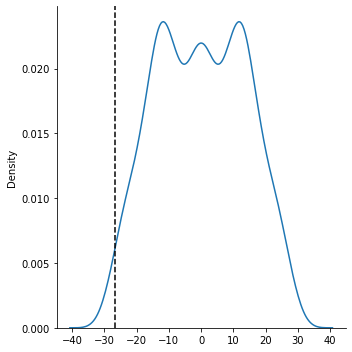

In [ ]:
import seaborn as sns
def PermutationPlot(all_diffs, orig_diff=None):
    g=sns.displot(all_diffs,kind='kde')
    if orig_diff:
        g.refline(x=orig_diff,color='k')

PermutationPlot(all_diffs,orig_diff)

In [ ]:
from scipy.stats import ttest_ind
import itertools
from math import factorial
import numpy as np

def PermutationTest(data,tails=2,verbose=False):
    # Your code here...
   
    return ptile,orig_diff,all_diffs

# Start by commenting out all but one of these analyses until you've got things going.
ptile,orig_diff,all_diffs=PermutationTest(OrigNullNorm)
print(f'Null, normal p={ptile:.3f}\n')

ptile,orig_diff,all_diffs=PermutationTest(OrigNullSkew)
print(f'Null effect, skew p={ptile:.3f}\n')

ptile,orig_diff,all_diffs=PermutationTest(OrigNorm)
print(f'Effect, normal p={ptile:.3f}\n')

ptile,orig_diff,all_diffs=PermutationTest(OrigSkew)
print(f'Effect, skew p={ptile:.3f}\n')




# Monte Carlo version
Well, 185k isn't so crazy for this kind of thing, but what if we needed a lot more math than just a simple difference? What if each iteration then took several seconds?  Or, what if we have larger samples than two groups of 10?  The time it takes to run a full permutation can get out of hand quickly.

Just as we can approximate how a population behaves by sampling it (the fundamental idea in all of statistics), we can approximate how our measure behaves by sampling it rather than by testing every possible point. That's what we do in a Monte Carlo analysis.

Here, re-write your code to just randomly shuffle the groups `nshuffles` times (default 1000), compute the difference each time and return the same percentile and "all differences" array as before. This should be a plug-in replacement for your `PermutationTest()` routine.  Run on all 4 datasets and you should see the p-values are darn close, even with the default of 1000 samples.


In [ ]:
from scipy.stats import ttest_ind
import numpy as np

def MonteCarloTest(data,nshuffles=1000,tails=2,verbose=False):
    # Your code here

    return ptile,orig_diff,all_diffs

ptile,orig_diff,all_diffs=MonteCarloTest(OrigNullNorm)
print(f'Null, normal p={ptile:.3f}\n')

ptile,orig_diff,all_diffs=MonteCarloTest(OrigNullSkew)
print(f'Null effect, skew p={ptile:.3f}\n')

ptile,orig_diff,all_diffs=MonteCarloTest(OrigNorm)
print(f'Effect, normal p={ptile:.3f}\n')

ptile,orig_diff,all_diffs=MonteCarloTest(OrigSkew)
print(f'Effect, skew p={ptile:.3f}\n')